### Disclaimer

- You need Python 3.10 or higher to run this demo
- Amazon Braket is a paid service, but there are free options: https://aws.amazon.com/braket/getting-started

In [1]:
import pennylane as qml
from pennylane import numpy as np

qml.about()

Name: PennyLane
Version: 0.32.0
Summary: PennyLane is a Python quantum machine learning library by Xanadu Inc.
Home-page: https://github.com/PennyLaneAI/pennylane
Author: 
Author-email: 
License: Apache License 2.0
Location: /Users/isaac/.virtualenvs/pennylane-braket/lib/python3.10/site-packages
Requires: appdirs, autograd, autoray, cachetools, networkx, numpy, pennylane-lightning, requests, rustworkx, scipy, semantic-version, toml, typing-extensions
Required-by: amazon-braket-pennylane-plugin, PennyLane-Lightning

Platform info:           macOS-14.1.1-arm64-arm-64bit
Python version:          3.10.13
Numpy version:           1.23.5
Scipy version:           1.11.3
Installed devices:
- default.gaussian (PennyLane-0.32.0)
- default.mixed (PennyLane-0.32.0)
- default.qubit (PennyLane-0.32.0)
- default.qubit.autograd (PennyLane-0.32.0)
- default.qubit.jax (PennyLane-0.32.0)
- default.qubit.tf (PennyLane-0.32.0)
- default.qubit.torch (PennyLane-0.32.0)
- default.qutrit (PennyLane-0.32.0)
- n

In [2]:
def circuit(params):
    qml.RX(params[0], wires=0)
    qml.RY(params[1], wires=0)
    return qml.expval(qml.PauliZ(0))

In [3]:
from braket.devices import Devices
from braket.aws import AwsDevice

qpu_device = Devices.Rigetti.AspenM3
qpu_device_arn = qpu_device.value

qpu_available = False

if AwsDevice(qpu_device_arn).is_available:
    device_arn = qpu_device_arn
    qpu_available = True

else:
    device_arn = "local:pennylane/lightning.qubit"
    print("AspenM3 is not available. Falling back to lightning.qubit simulator.")

AspenM3 is not available. Falling back to lightning.qubit simulator.


In [4]:
from braket.jobs import hybrid_job
from braket.jobs.metrics import log_metric

@hybrid_job(device=device_arn)
def qpu_qubit_rotation_hybrid_job(qpu_available=False):
    
    if qpu_available:
        device = qml.device(
            "braket.aws.qubit",
            device_arn=qpu_device_arn, 
            wires=1,
            shots=1_000,
        )
    else:
        device = qml.device(
            "braket.local.qubit", 
            wires=1
        )
    
    qnode = qml.QNode(circuit, device)

    opt = qml.GradientDescentOptimizer(stepsize=0.5)
    params = np.array([0.5, 0.75])

    for i in range(10):
        params = opt.step(qnode, params)
        expval = qnode(params)

        log_metric(metric_name="expval", iteration_number=i, value=expval)

    return params

In [5]:
qpu_job = qpu_qubit_rotation_hybrid_job(qpu_available=qpu_available)
qpu_job.result()

WARNING! Using --password via the CLI is insecure. Use --password-stdin.
Pulling docker container image. This may take a while.


Login Succeeded
latest: Pulling from amazon-braket-base-jobs
Digest: sha256:ef68dca06901f0ed9ed36731da584bc6f3d185b270859d8401f9b97a079ce266
Status: Image is up to date for 292282985366.dkr.ecr.us-east-1.amazonaws.com/amazon-braket-base-jobs:latest
292282985366.dkr.ecr.us-east-1.amazonaws.com/amazon-braket-base-jobs:latest



What's Next?
  View a summary of image vulnerabilities and recommendations → docker scout quickview 292282985366.dkr.ecr.us-east-1.amazonaws.com/amazon-braket-base-jobs:latest


Boto3 Version:  1.28.53
Beginning Setup
Checking for Additional Requirements
Additional Requirements Check Finished
Running Code As Process
Metrics - timestamp=1701289119.6940901; expval=0.38894534132396147; iteration_number=0;
Metrics - timestamp=1701289119.7338517; expval=0.12290715413453952; iteration_number=1;
Metrics - timestamp=1701289119.7734149; expval=-0.09181374013482183; iteration_number=2;
Metrics - timestamp=1701289119.8118005; expval=-0.29360940999485413; iteration_number=3;
Metrics - timestamp=1701289119.8504775; expval=-0.5344079938678081; iteration_number=4;
Metrics - timestamp=1701289119.889077; expval=-0.7715298984378991; iteration_number=5;
Metrics - timestamp=1701289119.9289715; expval=-0.9193547392516986; iteration_number=6;
Metrics - timestamp=1701289119.9674022; expval=-0.977154318618763; iteration_number=7;
Metrics - timestamp=1701289120.0063171; expval=-0.9940804663947356; iteration_number=8;
Metrics - timestamp=1701289120.044763; expval=-0.9985062848699056; i

{'result': tensor([0.03642036, 3.10081929], requires_grad=True)}

In [6]:
import pandas as pd

df = pd.DataFrame(qpu_job.metrics())
df.sort_values(by=["iteration_number"], inplace=True)

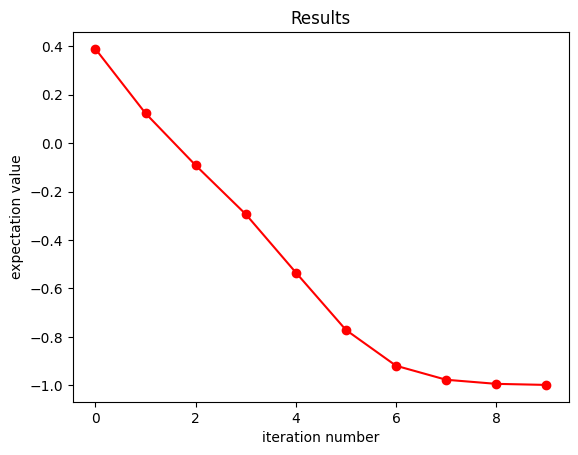

In [7]:
import matplotlib.pyplot as plt

plt.plot(df["iteration_number"], df["expval"], "-o", color="red")
plt.xlabel("iteration number")
plt.ylabel("expectation value")
plt.title("Results")
plt.show()